<h1 style="text-align: center; font-size: 2.3em; color: navy; font-family: Arial, sans-serif; font-weight: bold;">
Astrophysical Techniques – Homework 1 
</h1>

<h2 style="text-align: center; font-size: 2em; color: black; font-family: Arial, sans-serif;">
Estimation the Effect of Atmospheric Extinction
</h2>

<p style="text-align: center; font-size: 1.2em; font-family: Georgia, serif;">
Master in Astrophysics and Space Science (MASS)-(2024/2025) <br>
Department of Astronomy, University of Belgrade <br>
Instructor: Prof. Dragana Ilić
</p>

<p style="text-align: center; font-size: 1.2em; font-family: Georgia, serif; font-style: italic;">
Report by Nandita Das
</p>

## **Introduction**

Ground-based astronomical observations are fundamentally affected by the Earth's atmosphere. As electromagnetic radiation from celestial sources traverses the atmosphere, it undergoes scattering and absorption due to interactions with air molecules, aerosols, and water vapor. These processes reduce the apparent brightness of stars and other objects and introduce wavelength-dependent effects that must be corrected for in any precise photometric analysis. This phenomenon, known as **atmospheric extinction**, is one of the major sources of systematic error in optical astronomy.

Atmospheric extinction is most significant at low altitudes (i.e., high zenith angles), where the light must travel through a thicker column of atmosphere. The total attenuation depends not only on the intrinsic transparency of the atmosphere on a given night, but also on the **airmass**, which quantifies the optical path length relative to the zenith. Airmass increases with decreasing altitude and is approximately equal to 1 when a source is overhead.

To correct for this extinction and calibrate observed magnitudes, astronomers rely on **standard stars** — stars with well-established magnitudes in standard photometric systems, such as the Johnson–Cousins UBVRI system. By observing these stars at various altitudes and determining how their observed brightness changes with airmass, we can derive the **extinction coefficient** $k$, which describes the magnitude loss per unit airmass. This relationship follows the **Beer–Lambert law**, which in logarithmic form becomes:

$$
m_\text{inst} = m_0 + k \cdot X
$$

Where:

- $m_\text{inst}$ is the instrumental magnitude recorded at the telescope  
- $m_0$ is the magnitude the star would have above the atmosphere  
- $k$ is the extinction coefficient  
- $X$ is the airmass

This experiment is designed to measure the extinction coefficient $k_V$ in the Johnson V band. Observations of multiple standard stars were performed at various local sidereal times (LSTs), allowing each star to be observed at different altitudes and thus different airmasses. The instrumental magnitudes were calculated from photon counts recorded through V and B filters. Using coordinate transformations and airmass approximations based on the observer’s location and observing time, the airmass for each observation was computed. By performing linear regression between magnitude and airmass, the extinction coefficient $k_V$ was estimated.

Furthermore, we examined the color transformation between instrumental and standard magnitudes. Instrumental magnitudes are inherently affected by system response and atmospheric transparency, and are not directly comparable across different observing nights or instruments. To correct this, we established a linear transformation between the instrumental color index $(b - v)$ and the standard color index $(B - V)$, as well as a relationship between the instrumental V magnitude and the standard V magnitude.

Finally, we used these transformations to calibrate the magnitude of a previously uncharacterized target star. The procedures in this report thus illustrate the fundamental role of atmospheric extinction correction in modern photometry and demonstrate the methods required to convert raw observational data into calibrated, science-ready measurements.

## **Import Libraries**

In [1]:
# import stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import Angle 
from scipy.optimize import curve_fit

In [2]:
### Let's write down our data

# List of star names, each repeated 4 times (one for each observation)
stars = ['HR7235', 'HR7235', 'HR7235', 'HR7235', 
        'HR7298', 'HR7298', 'HR7298', 'HR7298', 
        'HR7377', 'HR7377', 'HR7377', 'HR7377', 
        'HR7387', 'HR7387', 'HR7387', 'HR7387',
        'HR7405', 'HR7405', 'HR7405', 'HR7405', 
        'HR7478', 'HR7478', 'HR7478', 'HR7478']

# Measured photon counts in the V filter for each observation
N_Vs = [1.49e7, 1.42e7, 1.32e7, 1.05e7,
        4.65e6, 4.33e6, 3.21e6, 3.61e6,
        1.04e7, 9.60e6, 8.33e6, 6.91e6,
        3.24e6, 2.82e6, 2.38e6, 1.91e6,
        3.92e6, 3.81e6, 3.45e6, 2.56e6,
        3.12e6, 3.12e6, 2.96e6, 2.38e6]

# Measured photon counts in the B filter for each observation
N_Bs = [4.90e7, 4.37e7, 4.03e7, 2.74e7,
        1.94e7, 1.79e7, 1.11e7, 1.24e7,
        2.82e7, 2.40e7, 1.97e7, 1.45e7,
        7.42e6, 5.67e6, 4.53e6, 3.01e6,
        4.37e6, 4.17e6, 3.58e6, 2.23e6,
        5.47e6, 5.52e6, 4.96e6, 3.42e6]

# Local Sidereal Time (LST) at which each observation was made
LSTs = ['19 29.6', '22 18.6', '23 10.2', '00 09.4',
        '19 32.8', '22 22.0', '23 13.6', '01 15.2',
        '19 36.0', '22 25.6', '23 17.1', '00 02.1',
        '19 39.5', '22 29.1', '23 21.0', '00 05.9',
        '19 43.1', '22 32.8', '23 24.4', '01 19.0',
        '19 46.9', '22 36.7', '23 28.7', '01 23.1']

# Create the initial DataFrame
df = pd.DataFrame({'star': stars, 'N_V': N_Vs, 'N_B': N_Bs, 'LST': LSTs})

# Display the first few rows
df

,star,N_V,N_B,LST
0,HR7235,14900000.0,49000000.0,19 29.6
1,HR7235,14200000.0,43700000.0,22 18.6
2,HR7235,13200000.0,40300000.0,23 10.2
3,HR7235,10500000.0,27400000.0,00 09.4
4,HR7298,4650000.0,19400000.0,19 32.8
5,HR7298,4330000.0,17900000.0,22 22.0
6,HR7298,3210000.0,11100000.0,23 13.6
7,HR7298,3610000.0,12400000.0,01 15.2
8,HR7377,10400000.0,28200000.0,19 36.0
9,HR7377,9600000.0,24000000.0,22 25.6


In [3]:
simbad = Simbad()  # Create a Simbad query object

# Add B and V magnitudes to the query result using VOTable fields
simbad.add_votable_fields("flux(B)", "flux(V)")

/var/folders/zm/gqp_q1cx5ql75g30zx8blmv00000gn/T/ipykernel_84740/308915671.py:4: DeprecationWarning: The notation 'flux(B)' is deprecated since 0.4.8 in favor of 'B'. You will see the column appearing with its new name in the output. See section on filters in https://astroquery.readthedocs.io/en/latest/simbad/simbad_evolution.html to see the new ways to interact with SIMBAD's fluxes.
  simbad.add_votable_fields("flux(B)", "flux(V)")
/var/folders/zm/gqp_q1cx5ql75g30zx8blmv00000gn/T/ipykernel_84740/308915671.py:4: DeprecationWarning: The notation 'flux(V)' is deprecated since 0.4.8 in favor of 'V'. You will see the column appearing with its new name in the output. See section on filters in https://astroquery.readthedocs.io/en/latest/simbad/simbad_evolution.html to see the new ways to interact with SIMBAD's fluxes.
  simbad.add_votable_fields("flux(B)", "flux(V)")


In [4]:
# Query SIMBAD for each star in the DataFrame and store the result tables in a list
simbad_tables = [simbad.query_object(star) for star in df['star']]

In [5]:
# Extract RA, DEC, B, and V magnitudes from each SIMBAD result table
RAs, DECs, Vs, Bs = [], [], [], []

for star_table in simbad_tables:
    RA_HA = star_table['ra'][0]     # Right Ascension in HMS string format
    DEC_DMS = star_table['dec'][0]  # Declination in DMS string format
    V = star_table['V'][0]          # V magnitude
    B = star_table['B'][0]          # B magnitude

    RAs.append(RA_HA)
    DECs.append(DEC_DMS)
    Vs.append(V)
    Bs.append(B)

# Add the extracted values as new columns to the DataFrame
df['RA_HA'] = RAs
df['DEC_DMS'] = DECs
df['V'] = Vs
df['B'] = Bs

df.head()

,star,N_V,N_B,LST,RA_HA,DEC_DMS,V,B
0,HR7235,14900000.0,49000000.0,19 29.6,286.352533,13.863477,2.990,3.000
1,HR7235,14200000.0,43700000.0,22 18.6,286.352533,13.863477,2.990,3.000
2,HR7235,13200000.0,40300000.0,23 10.2,286.352533,13.863477,2.990,3.000
3,HR7235,10500000.0,27400000.0,00 09.4,286.352533,13.863477,2.990,3.000
4,HR7298,4650000.0,19400000.0,19 32.8,288.439535,39.145966,4.398,4.243


In [6]:
# Convert RA (HMS) and DEC (DMS) string values to decimal degrees
RAs_deg, DECs_deg = [], []

for index, row in df.iterrows():
    ra_HA = row['RA_HA']        # Right Ascension as HMS string (e.g., '19 29.6')
    dec_DMS = row['DEC_DMS']    # Declination as DMS string (e.g., '+45 12 30')
    
    # Use SkyCoord for coordinate conversion
    coord = SkyCoord(ra_HA, dec_DMS, unit=(u.hourangle, u.deg))
    
    # Append converted decimal degree values
    RAs_deg.append(coord.ra.deg)
    DECs_deg.append(coord.dec.deg)

# Store decimal values in the DataFrame
df['ra_DEG'] = RAs_deg
df['dec_DEG'] = DECs_deg

df.head()

,star,N_V,N_B,LST,RA_HA,DEC_DMS,V,B,ra_DEG,dec_DEG
0,HR7235,14900000.0,49000000.0,19 29.6,286.352533,13.863477,2.990,3.000,335.288001,13.863477
1,HR7235,14200000.0,43700000.0,22 18.6,286.352533,13.863477,2.990,3.000,335.288001,13.863477
2,HR7235,13200000.0,40300000.0,23 10.2,286.352533,13.863477,2.990,3.000,335.288001,13.863477
3,HR7235,10500000.0,27400000.0,00 09.4,286.352533,13.863477,2.990,3.000,335.288001,13.863477
4,HR7298,4650000.0,19400000.0,19 32.8,288.439535,39.145966,4.398,4.243,6.593026,39.145966


In [7]:
# Define Toronto observatory latitude in degrees and convert to radians
observatory_lat_deg = 43 + (52 / 60)  # 43 degrees 52 minutes
observatory_lat_rad = np.radians(observatory_lat_deg)

# Function to calculate cos(Z) based on LST, RA, and DEC
def calculate_cos_Z(LST_HA, RA_deg, DEC_deg):
    # Convert LST string (e.g., "10 30") to degrees
    LST_deg = Angle(LST_HA, unit=u.hourangle).degree
    hour_angle_deg = LST_deg - RA_deg
    hour_angle_rad = np.radians(hour_angle_deg)
    DEC_rad = np.radians(DEC_deg)

    # cos(Z) formula: projection of the star altitude angle
    cos_Z = np.sin(observatory_lat_rad) * np.sin(DEC_rad) + \
            np.cos(observatory_lat_rad) * np.cos(DEC_rad) * np.cos(hour_angle_rad)
    return cos_Z

# Calculate cos(Z) for each star and store in a new column
cos_Zs = []
for index, row in df.iterrows():
    cos_Z = calculate_cos_Z(row['LST'], row['ra_DEG'], row['dec_DEG'])
    cos_Zs.append(cos_Z)

df['cos_Z'] = cos_Zs
df.head()

,star,N_V,N_B,LST,RA_HA,DEC_DMS,V,B,ra_DEG,dec_DEG,cos_Z
0,HR7235,14900000.0,49000000.0,19 29.6,286.352533,13.863477,2.990,3.000,335.288001,13.863477,0.678890
1,HR7235,14200000.0,43700000.0,22 18.6,286.352533,13.863477,2.990,3.000,335.288001,13.863477,0.865954
2,HR7235,13200000.0,40300000.0,23 10.2,286.352533,13.863477,2.990,3.000,335.288001,13.863477,0.850029
3,HR7235,10500000.0,27400000.0,00 09.4,286.352533,13.863477,2.990,3.000,335.288001,13.863477,0.789363
4,HR7298,4650000.0,19400000.0,19 32.8,288.439535,39.145966,4.398,4.243,6.593026,39.145966,0.597281


In [8]:
# Convert cos(Z) values to airmass using an empirical correction formula

def cosZ_to_airmass(cos_Z):
    if cos_Z > 0:
        # Apply airmass formula with refraction correction
        airmass = (1 / cos_Z) * (1 - 0.0012 * ((1 / cos_Z**2) - 1))
    else:
        # Invalid geometry (star below horizon)
        airmass = np.inf
    return airmass

# Apply to the whole DataFrame and store as a new column 'X'
df['X'] = df['cos_Z'].apply(cosZ_to_airmass)
df.head()

,star,N_V,N_B,LST,RA_HA,DEC_DMS,V,B,ra_DEG,dec_DEG,cos_Z,X
0,HR7235,14900000.0,49000000.0,19 29.6,286.352533,13.863477,2.990,3.000,335.288001,13.863477,0.678890,1.470925
1,HR7235,14200000.0,43700000.0,22 18.6,286.352533,13.863477,2.990,3.000,335.288001,13.863477,0.865954,1.154333
2,HR7235,13200000.0,40300000.0,23 10.2,286.352533,13.863477,2.990,3.000,335.288001,13.863477,0.850029,1.175888
3,HR7235,10500000.0,27400000.0,00 09.4,286.352533,13.863477,2.990,3.000,335.288001,13.863477,0.789363,1.265925
4,HR7298,4650000.0,19400000.0,19 32.8,288.439535,39.145966,4.398,4.243,6.593026,39.145966,0.597281,1.670633


In [9]:
# Calculating instrument magnitudes

def return_instrument_mag(N_photons):
    return -2.5 * np.log10(N_photons)

df['V_ins'] = df['N_V'].apply(return_instrument_mag)
df['B_ins'] = df['N_B'].apply(return_instrument_mag)

In [10]:
# Fitting for gamma and beta with Scipy curve_fit

df['V-V_ins'] = df['V'] - df['V_ins']
df['B_ins-V_ins'] = df['B_ins'] - df['V_ins']

def linear_fit(x, m, c):
    return m * x + c

params, _ = curve_fit(linear_fit, df['B_ins-V_ins'].to_numpy(), df['V-V_ins'].to_numpy())
gamma, beta = params[0], params[1]

print('Gamma:\t', gamma)
print('Beta:\t', beta)

Gamma:	 -0.11787693721908288
Beta:	 20.687034303169842


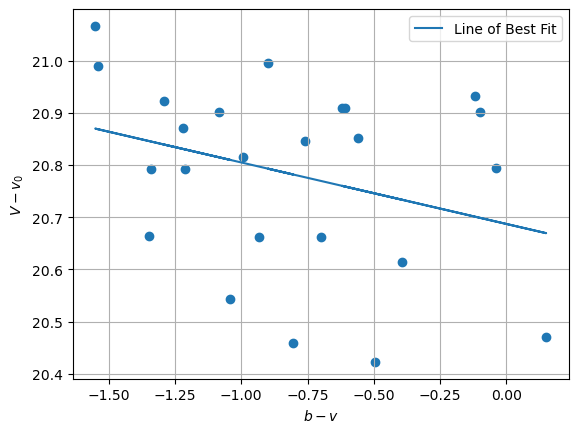

In [11]:
# Plot the transformation relation between instrumental and standard magnitudes

# Scatter plot: instrumental color index (b - v) vs difference (V - v₀)
plt.scatter(df['B_ins-V_ins'].to_numpy(), df['V-V_ins'].to_numpy())

# Plot the best-fit line using gamma (slope) and beta (intercept)
plt.plot(df['B_ins-V_ins'].to_numpy(),
         df['B_ins-V_ins'].to_numpy() * gamma + beta,
        label='Line of Best Fit')

plt.xlabel('$b-v$')          # Instrumental color index
plt.ylabel('$V-v_0$')        # Difference between standard and instrumental V magnitudes
plt.legend()
plt.grid()

In [12]:
# Doing the same for eta and epsilon

df['B-V'] = df['B'] - df['V']

def linear_fit(x, m, c):
    return m * x + c

params, _ = curve_fit(linear_fit, df['B_ins-V_ins'].to_numpy(), df['B-V'].to_numpy())
epsilon, eta = params[0], params[1]

print('Epsilon:\t', epsilon)
print('Eta:\t\t', eta)

Epsilon:	 1.1602652408347853
Eta:		 1.4818180804431966


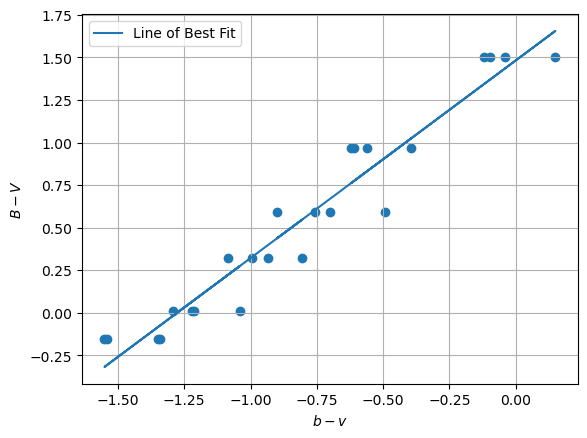

In [13]:
# Plot the transformation from instrumental to standard color index

# Scatter plot: instrumental color (b - v) vs. standard color index (B - V)
plt.scatter(df['B_ins-V_ins'].to_numpy(), df['B-V'].to_numpy())

# Plot best-fit transformation line using epsilon (slope) and eta (intercept)
plt.plot(df['B_ins-V_ins'].to_numpy(),
         df['B_ins-V_ins'].to_numpy() * epsilon + eta,
        label='Line of Best Fit')

plt.xlabel('$b-v$')     # Instrumental color index
plt.ylabel('$B-V$')     # Standard color index
plt.grid()
plt.legend()

In [14]:
df.head()

,star,N_V,N_B,LST,RA_HA,DEC_DMS,V,B,ra_DEG,dec_DEG,cos_Z,X,V_ins,B_ins,V-V_ins,B_ins-V_ins,B-V
0,HR7235,14900000.0,49000000.0,19 29.6,286.352533,13.863477,2.990,3.000,335.288001,13.863477,0.678890,1.470925,-17.932966,-19.225490,20.922966,-1.292525,0.010
1,HR7235,14200000.0,43700000.0,22 18.6,286.352533,13.863477,2.990,3.000,335.288001,13.863477,0.865954,1.154333,-17.880721,-19.101204,20.870721,-1.220483,0.010
2,HR7235,13200000.0,40300000.0,23 10.2,286.352533,13.863477,2.990,3.000,335.288001,13.863477,0.850029,1.175888,-17.801435,-19.013263,20.791435,-1.211828,0.010
3,HR7235,10500000.0,27400000.0,00 09.4,286.352533,13.863477,2.990,3.000,335.288001,13.863477,0.789363,1.265925,-17.552973,-18.594376,20.542973,-1.041403,0.010
4,HR7298,4650000.0,19400000.0,19 32.8,288.439535,39.145966,4.398,4.243,6.593026,39.145966,0.597281,1.670633,-16.668632,-18.219504,21.066632,-1.550872,-0.155


In [15]:
# Populating observed reference star magnitudes using the instrumental magnitudes

def return_V_obs(Bins_minus_Vins, V_ins):
    return beta + gamma * Bins_minus_Vins + V_ins

df['V_obs'] = df.apply(lambda row: return_V_obs(row['B_ins-V_ins'], row['V_ins']), axis=1)
df.head()

,star,N_V,N_B,LST,RA_HA,DEC_DMS,V,B,ra_DEG,dec_DEG,cos_Z,X,V_ins,B_ins,V-V_ins,B_ins-V_ins,B-V,V_obs
0,HR7235,14900000.0,49000000.0,19 29.6,286.352533,13.863477,2.990,3.000,335.288001,13.863477,0.678890,1.470925,-17.932966,-19.225490,20.922966,-1.292525,0.010,2.906427
1,HR7235,14200000.0,43700000.0,22 18.6,286.352533,13.863477,2.990,3.000,335.288001,13.863477,0.865954,1.154333,-17.880721,-19.101204,20.870721,-1.220483,0.010,2.950180
2,HR7235,13200000.0,40300000.0,23 10.2,286.352533,13.863477,2.990,3.000,335.288001,13.863477,0.850029,1.175888,-17.801435,-19.013263,20.791435,-1.211828,0.010,3.028446
3,HR7235,10500000.0,27400000.0,00 09.4,286.352533,13.863477,2.990,3.000,335.288001,13.863477,0.789363,1.265925,-17.552973,-18.594376,20.542973,-1.041403,0.010,3.256818
4,HR7298,4650000.0,19400000.0,19 32.8,288.439535,39.145966,4.398,4.243,6.593026,39.145966,0.597281,1.670633,-16.668632,-18.219504,21.066632,-1.550872,-0.155,4.201214


In [16]:
# Select only valid data points:
# - X must be finite, greater than 0, and less than 3 (physically reasonable airmass range)
# - V must be finite (no NaN or inf magnitudes)
valid = np.isfinite(df['X']) & (df['X'] > 0) & (df['X'] < 3) & np.isfinite(df['V'])

# Convert the filtered X and V columns to NumPy arrays for curve fitting
X_clean = df['X'][valid].to_numpy()
V_clean = df['V'][valid].to_numpy()

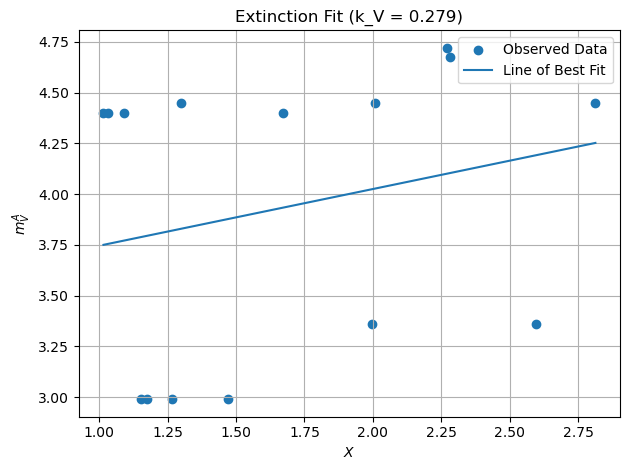

In [17]:
# Perform linear curve fitting to find extinction coefficient k_V and intercept m
params, _ = curve_fit(linear_fit, X_clean, V_clean)
k_V, m = params  # k_V is the slope (extinction coefficient), m is the intercept

# Sort X values for plotting a clean, connected line
sorted_idx = np.argsort(X_clean)

# Plot the observed (cleaned) data points
plt.scatter(X_clean, V_clean, label='Observed Data')

# Plot the fitted line using the sorted X values
plt.plot(X_clean[sorted_idx],
        (X_clean * k_V + m)[sorted_idx],
        label='Line of Best Fit')

# Label axes and add plot elements
plt.xlabel('$X$')           # Airmass
plt.ylabel('$m_V^A$')       # Instrumental V-band magnitude
plt.grid()
plt.legend()
plt.title(f'Extinction Fit (k_V = {k_V:.3f})')  # Display fitted slope in title
plt.tight_layout()
plt.show()

In [18]:
target_V_estimate = gamma * (return_instrument_mag(7.7E5) - return_instrument_mag(3.56E5)) + beta + return_instrument_mag(3.56E5)

print('The estimated true V magnitude of our star is {:.3f}'.format(target_V_estimate))

The estimated true V magnitude of our star is 6.907


In [19]:
# Let's check the target star around its coordinates.

target_table = simbad.query_region(SkyCoord(ra='19h34.1m', dec='+31d18m'), radius=100 * u.arcsec)
target_table

main_id,ra,dec,coo_err_maj,coo_err_min,coo_err_angle,coo_wavelength,coo_bibcode,B,V
,deg,deg,mas,mas,deg,,,,
object,float64,float64,float32,float32,int16,str1,object,float64,float64
Gaia DR3 2044818055433168768,293.5217321563908,31.30481721274166,0.0786,0.0908,90,O,2020yCat.1350....0G,--,--


The target star does not have UBV mags, but does have Gaia magnitudes. The G-band Gaia magnitude is around 18, which is very far away.